In [10]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [12]:
from opxrd.wrapper import OpXRD
from opxrd.analysis import PlotAnalysis

import warnings
warnings.filterwarnings('ignore')

t1 = '/media/daniel/mirrors/xrd.aimat.science/local/final/CNRS'
t2 = '/media/daniel/mirrors/xrd.aimat.science/local/final/EMPA'
full_dirpath = '/media/daniel/mirrors/xrd.aimat.science/local/final'

# d1 = OpXRD.load(dirpath=t1)
d2 = OpXRD.load(dirpath=t2)
# full_dbs = OpXRD.load_project_list(root_dirpath=full_dirpath)

analyser = PlotAnalysis(databases=[d2], output_dirpath='/tmp/opxrd_analysis')

  1% (10 of 770) |                       | Elapsed Time: 0:00:00 ETA:   0:00:03

Loading patterns from local dirpath /media/daniel/mirrors/xrd.aimat.science/local/final/EMPA


ValueError: Failed to parse file /media/daniel/mirrors/xrd.aimat.science/local/final/EMPA/pattern_53.json:
- Reason: ValueError('Phase fraction must be between 0 and 1. Got 81.0')

---> Combined pattern plot for databaes ['a:EMPA'] | No. patterns = 50

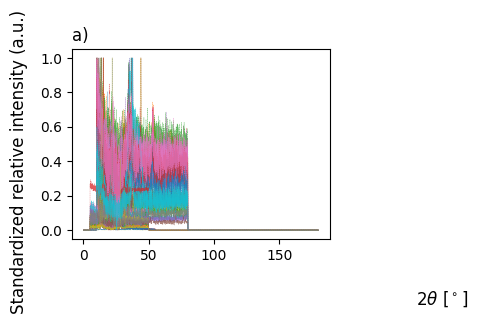

In [3]:
analyser.plot_in_single(limit_patterns=50)

---> Cumulative explained variance ratio $v$ over components |  $v =  \frac{\sum_i \lambda_i}{\sum^n_{j=1} \lambda_j}$

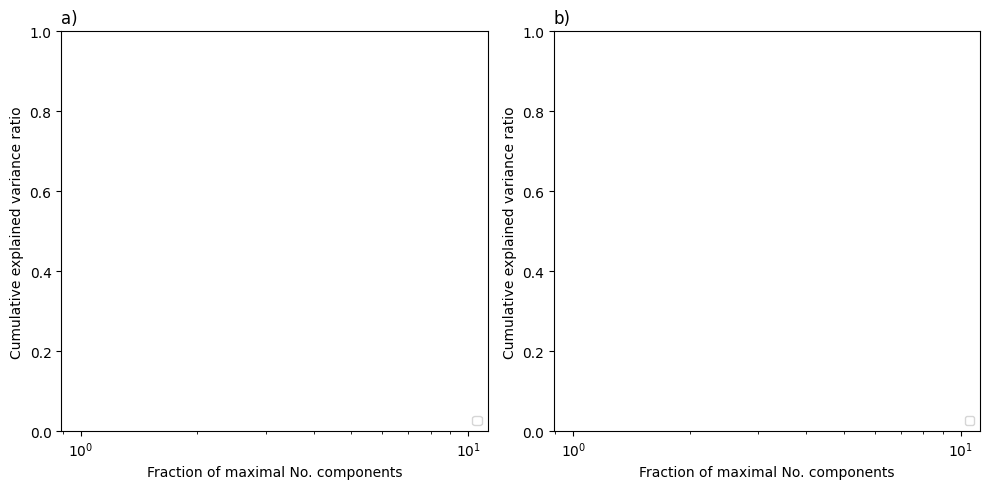

---> Cumulative explained variance ratio $v$ over components |  $v =  \frac{\sum_i \lambda_i}{\sum^n_{j=1} \lambda_j}$

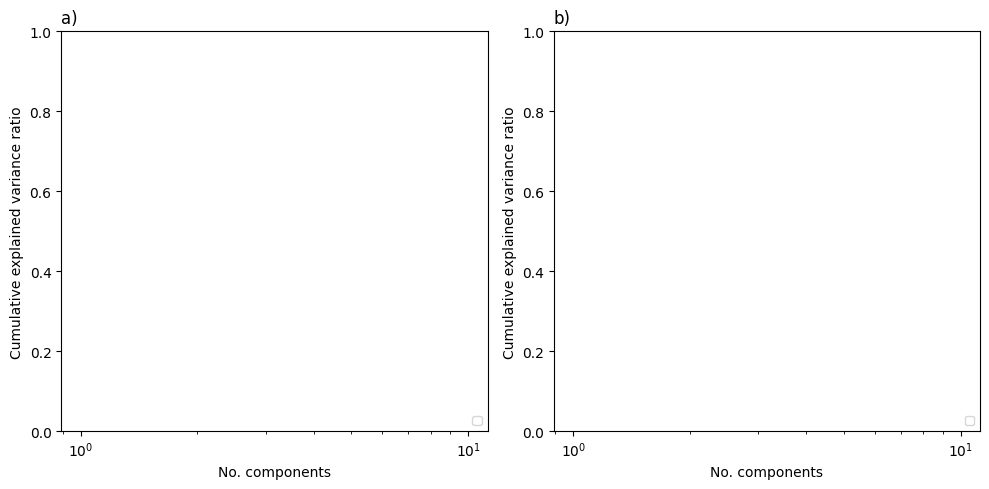

In [4]:
analyser.plot_effective_components()
analyser.plot_effective_components(use_fractions=False)

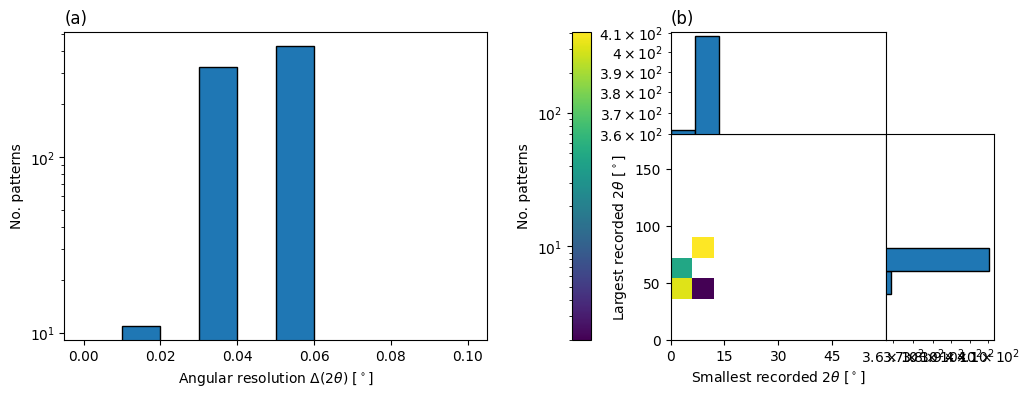

---> Histograms detailing properties of all diffraction patterns in the opXRD database: a) distribution of angular resolutions; b) distribution of smallest and largest recorded 2θ values.

In [5]:
analyser.xrd_histogram()
analyser.print_text(f'---> Histograms detailing properties of all diffraction patterns in the opXRD database: a) distribution of angular resolutions; b) distribution of smallest and largest recorded 2θ values.')

ValueError: No data found for attribute primary_phase.num_atoms

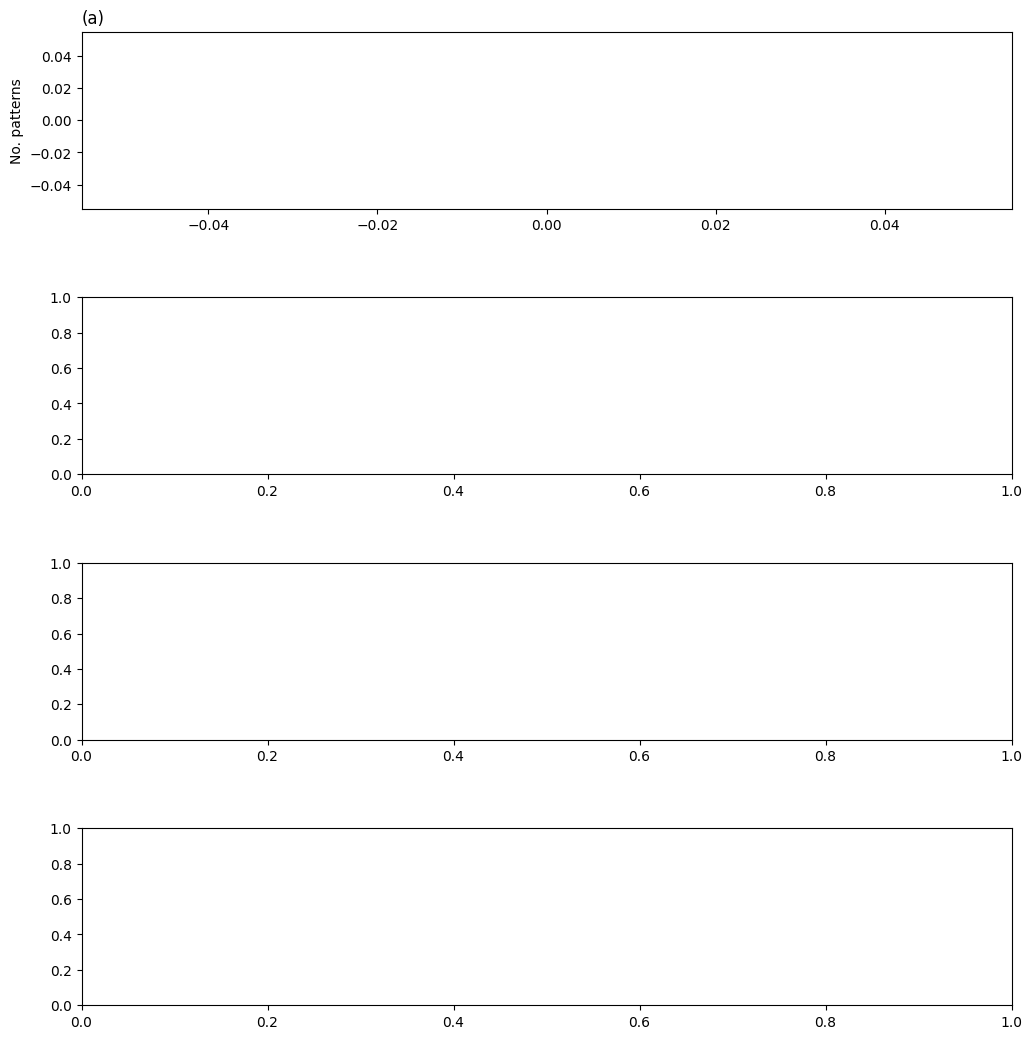

In [6]:
analyser.structure_histogram()
analyser.print_text(f'---> Histograms detailing properties of the structures underlying labeled diffraction patterns in the opXRD database: '
                    f'a) distribution of structures containing specified elements;'
                    r'b) distribution of structures containing spacegroups; '
                    r'c) distribution of No. atoms N_{\text{atom}} contained in unit cell; '
                    r'd) distribution of unit cell volume V_{\text{uc}}')

In [7]:
analyser.show_label_fractions()

---> Overview of label fractions per contribution

+-------------+----------------+-----------+-------+---------+---------------+
|             |   No. patterns | lattice   | spg   | basis   | composition   |
|-------------+----------------+-----------+-------+---------+---------------|
| EMPA        |            770 | 0.0       | 0.0   | 0.0     | 0.0           |
| Σ Labeled   |              0 | #         | #     | #       | #             |
| Σ Unlabeled |            770 | 0.0       | 0.0   | 0.0     | 0.0           |
+-------------+----------------+-----------+-------+---------+---------------+
